In [ ]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

dataset: https://github.com/ucdaviscl/cowsl2h

Background:
The UC Davis Corpus of Written Spanish, L2 and Heritage Speakers (COWSL2H) consists of short essays collected from students enrolled in university-level Spanish courses.


Column information:
- Course enrolled
- Age
- Got ender
- L1 language
- Other L1 language(s)
- Language(s) spoken at home
- Language(s) studied
- listening comprehension *
- reading comprehension *
- speaking ability **
- writing ability **

*Annotations*: We have annotated a subset of essays for gender/number agreement and usage of "a personal." These annotation targets were chosen based on specific research questions


### loading data

In [ ]:
lists = ['famous.F17.csv', 'famous.S17.csv', 'famous.S18.csv', 'famous.SU17.csv', 'famous.W18.csv']

In [ ]:
for i in lists:
  os.system(f'wget https://raw.githubusercontent.com/ucdaviscl/cowsl2h/master/csv/{i}')

In [ ]:
!ls

famous.F17.csv	famous.S18.csv	 famous.W18.csv
famous.S17.csv	famous.SU17.csv  sample_data


In [ ]:
df = pd.read_csv('famous.F17.csv')

In [ ]:
#union all the data
for i in lists[1:]:
  df_temp = pd.read_csv(i)
  df = pd.concat([df, df_temp], axis=0)

In [ ]:
df[:10]

,Unnamed: 0,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,...,reading comprehension,speaking ability,writing ability,study abroad,essay,a personal annotator1,a personal annotator2,gender-number annotator1,gender-number annotator2,corrected
0,0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,...,3.0,1.0,1.0,No,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...
1,1,104622,famous,F17,SPA 3,20,Female,English,Not Applicable,No,...,3.0,3.0,3.0,No,Yo veo un programa de television que es muy di...,Yo veo un programa de television que es muy di...,Yo veo un programa de television que es muy di...,Yo veo un programa de television que es muy di...,Yo veo un programa de television que es muy di...,Yo veo un programa de televisión que es muy di...
2,2,169693,famous,F17,SPA 24,18 as of April 2017,Female,English,NaN,NaN,...,3.0,2.0,3.0,No,Antes de contarles de una persona famosa quien...,Antes de contarles de una persona famosa quien...,Antes de contarles de una persona famosa quien...,Antes de contarles de una persona famosa quien...,Antes de contarles de una persona famosa quien...,Antes de contarles sobre una persona famosa qu...
3,3,179355,famous,F17,SPA 1,20,Female,Other,Japanese,Japanese,...,3.0,1.0,2.0,No,Voy a prensentar una chica famosa en Japón. S...,Voy a prensentar una chica famosa en Japón. S...,Voy a prensentar []{a}<az:do:an> una chica fa...,Voy a prensentar una chica famosa en Japón. S...,Voy a prensentar una chica famosa en Japón. S...,Voy a presentar a una chica famosa en Japón. S...
4,4,148244,famous,F17,SPA 3,19,Male,Mandarin,NaN,I speak mandarin at home,...,4.0,4.0,5.0,No,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...
5,5,146552,famous,F17,SPA 1,19 years old.,Female,Mandarin,NaN,Mandarin.,...,3.0,1.0,2.0,Yes,Quiero escribir una persona famosa en la compo...,Quiero escribir una persona famosa en la compo...,Quiero escribir una persona famosa en la compo...,Quiero escribir una persona famosa en la compo...,Quiero escribir una persona famosa en la compo...,Quiero escribir sobre una persona famosa. Se l...
6,6,113384,famous,F17,SPA 31,21,Female,Spanish,NaN,Spanish,...,4.0,3.0,3.0,Yes,Cesar Chávez es una persona muy conocida por l...,Cesar Chávez es una persona muy conocida por l...,Cesar Chávez es una persona muy conocida por l...,Cesar Chávez es una persona muy conocida por l...,Cesar Chávez es una persona muy conocida por l...,Cesar Chávez es una persona muy conocida por l...
7,7,176553,famous,F17,SPA 1,18,Female,Mandarin,NaN,Mandarin,...,4.0,3.0,3.0,No,Maya angelou es una escritora famosa. Ella esc...,Maya angelou es una escritora famosa. Ella esc...,Maya angelou es una escritora famosa. Ella esc...,Maya angelou es una escritora famosa. Ella esc...,Maya angelou es una escritora famosa. Ella esc...,Maya Angelou es una escritora famosa. Ella esc...
8,8,148235,famous,F17,SPA 23,19,Female,English,NaN,no.,...,3.0,2.0,2.0,No,“El Chapo”--\n\n Joaquín Guzmán ...,“El Chapo”--\n\n Joaquín Guzmán ...,El Chapo”--\n\n Joaquín Guzmán L...,“El Chapo”--\n\n Joaquín Guzmán ...,“El Chapo”--\n\n Joaquín Guzmán ...,"“El Chapo” -- Joaquín Guzmán Loera, un capo de..."
9,9,147203,famous,F17,SPA 31,19,Female,Spanish,NaN,Spanish,...,4.0,5.0,4.0,Yes,\n\nUn artista que me encantaba más fue Ariel...,Un artista que me encantaba más fue Ariel Cama...,Un artista que me encantaba más fue Ariel Cama...,\nUn artista que me encantaba más fue Ariel Ca...,\nUn artista que me encantaba más fue Ariel Ca...,Un artista q

### Total Paragraphs/ Sample Sizes

In [ ]:
df.shape

(905, 22)

### Sanity Check

In [ ]:
df['essay'].isnull().count()

905

In [ ]:
unique_counts = df['essay'].nunique()
print(unique_counts)

904


In [ ]:
df[df['essay'].duplicated()==True]


,Unnamed: 0,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,...,reading comprehension,speaking ability,writing ability,study abroad,essay,a personal annotator1,a personal annotator2,gender-number annotator1,gender-number annotator2,corrected
41,41,150930,famous,S17,SPA 2,18,Female,English,NaN,Punjabi,...,2.0,2.0,2.0,No,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...


In [ ]:
df[df['id']== 150930]

,Unnamed: 0,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,...,reading comprehension,speaking ability,writing ability,study abroad,essay,a personal annotator1,a personal annotator2,gender-number annotator1,gender-number annotator2,corrected
41,41,150930,famous,F17,SPA 3,19,Female,English,NaN,Punjabi,...,2.0,2.0,2.0,No,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...
41,41,150930,famous,S17,SPA 2,18,Female,English,NaN,Punjabi,...,2.0,2.0,2.0,No,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...,Jennifer Lopez es una cantante famosa. Su nomb...


### adding paragraph ID

In [ ]:
df['paragraph_id'] = range(1,len(df)+1)

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df

,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,language(s) studied,...,speaking ability,writing ability,study abroad,essay,a personal annotator1,a personal annotator2,gender-number annotator1,gender-number annotator2,corrected,paragraph_id
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,1.0,1.0,No,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,Una persona famosa que admiro es Lauren Jaureg...,1
1,104622,famous,F17,SPA 3,20,Female,English,Not Applicable,No,Not Applicable,...,3.0,3.0,No,Yo veo un programa de television que es muy di...,Yo veo un programa de television que es muy di...,Yo veo un programa de television que es muy di...,Yo veo un programa de television que es muy di...,Yo veo un programa de television que es muy di...,Yo veo un programa de televisión que es muy di...,2
2,169693,famous,F17,SPA 24,18 as of April 2017,Female,English,NaN,NaN,NaN,...,2.0,3.0,No,Antes de contarles de una persona famosa quien...,Antes de contarles de una persona famosa quien...,Antes de contarles de una persona famosa quien...,Antes de contarles de una persona famosa quien...,Antes de contarles de una persona famosa quien...,Antes de contarles sobre una persona famosa qu...,3
3,179355,famous,F17,SPA 1,20,Female,Other,Japanese,Japanese,English more than 10 years,...,1.0,2.0,No,Voy a prensentar una chica famosa en Japón. S...,Voy a prensentar una chica famosa en Japón. S...,Voy a prensentar []{a}<az:do:an> una chica fa...,Voy a prensentar una chica famosa en Japón. S...,Voy a prensentar una chica famosa en Japón. S...,Voy a presentar a una chica famosa en Japón. S...,4
4,148244,famous,F17,SPA 3,19,Male,Mandarin,NaN,I speak mandarin at home,English 12 years,...,4.0,5.0,No,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,Mi cantante favorita es Taylor Swift. Me gusta...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,174783,famous,W18,SPA 1,Female,18,Mandarin,no,Mandarin,English. Over ten years.,...,2.0,2.0,No,Una Persona Famosa\n\nSelena Gomez es de los E...,Una Persona Famosa\n\nSelena Gomez es de los E...,Una Persona Famosa\n\nSelena Gomez es de los E...,Una Persona Famosa\n\nSelena Gomez es de los E...,Una Persona Famosa\n\nSelena Gomez es de los E...,NaN,901
176,170361,famous,W18,SPA 2,Female,20,Mandarin,NaN,"Yes, I speak mandarin mainly at home.",I studied English since I was five. (studied f...,...,1.0,2.0,No,Elsa es un personaje en una película famoso qu...,Elsa es un personaje en una película famoso qu...,Elsa es un personaje en una película famoso qu...,Elsa es un personaje en una película [famoso]{...,Elsa es un personaje en una película [famoso]{...,NaN,902
177,185467,famous,W18,SPA 2,Female,18,English,NaN,NaN,NaN,...,2.0,3.0,No,Britney Spears es treinta y seis años. Ella no...,Britney Spears es treinta y seis años. Ella no...,Britney Spears es treinta y seis años. Ella no...,Britney Spears es treinta y seis años. Ella no...,Britney Spears es treinta y seis años. Ella no...,NaN,903
178,132496,famous,W18,SPA 3,Female,20,English,NaN,NaN,None,...,2.0,4.0,No,Aly Raisman es una gimnasta olímpica. Personal...,Aly Raisman es una gimnasta olímpica. Personal...,Aly Raisman es una gimnasta olímpica. Personal...,Aly Raisman es una gimnasta olímpica. Personal...,Aly Raisman es una gimnasta olímpica. Personal...,NaN,904


In [ ]:
df.to_csv('correct_output.csv', index = False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 179
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        905 non-null    int64  
 1   prompt                    905 non-null    object 
 2   quarter                   905 non-null    object 
 3   course                    893 non-null    object 
 4   age                       887 non-null    object 
 5   gender                    889 non-null    object 
 6   l1 language               886 non-null    object 
 7   other l1 language(s)      177 non-null    object 
 8   language(s) used at home  641 non-null    object 
 9   language(s) studied       507 non-null    object 
 10  listening comprehension   827 non-null    float64
 11  reading comprehension     827 non-null    float64
 12  speaking ability          827 non-null    float64
 13  writing ability           826 non-null    float64
 14  study abro

###  Continue to clean the weird formated string


In [ ]:
pd.set_option('max_colwidth', 10000)
df[df['id']==125485].essay

205    ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
pattern = r'-{2,}'
df['essay'] =df['essay'].apply(lambda x: re.sub(pattern , '', x))

### removing the leading and trailing '/n'

In [ ]:
df[df['id']==125485].essay

205    \nCara Delevingne es una actriz. Ella es muy bonita, delgada, y rubia. En la televisión, ella es divertida y cómica. Cara puede cantar también. Ella es más famosa por una película que se llama "Ciudades de Papel." En esta película, Cara es una mujer de la que el actor principal está enamorado. Cara modela la ropa íntima y las marcas caras, entonces ella gana mucho dinero. Cara es de Hammersmith, Londres. Ella dejó la escuela en 2009,  y tuvo su primera apirición en la colección de otoño y invierno para Burberry. Después de este actuación de 2011, se hizo más y más famosa. Ella va en muchos programas para hablar de sus nuevas películas y proyectos. A veces, ella muestra sus diferentes talentos como "beatboxing." Ella es juguetona con otros actores y actrices y es realmente lindo. Tengo un gran enamoramiento por ella. Aunque ella es bella, Cara es más conocida por su personalidad. Más recientemente, estuvo en la película "Escuadrón suicida" donde ella es la villana. Ella es más ba

In [ ]:
# df['essay_new'] = df['essay'].str.replace('\\n', '.')
# df['essay_new']= df['essay_new'].str.replace('\\..','.')

In [ ]:
df[df['paragraph_id'] == 696].essay_new

AttributeError: ignored

In [ ]:
# df['a personal annotator1'] = df['a personal annotator1'].astype(str).str.replace('\\n', '.')
# df['a personal annotator1']= df['a personal annotator1'].astype(str).str.replace('\\..','.')

# df['a personal annotator2'] = df['a personal annotator2'].astype(str).str.replace('\\n', '.')
# df['a personal annotator2']= df['a personal annotator2'].astype(str).str.replace('\\..','.')

# df['gender-number annotator1'] = df['gender-number annotator1'].astype(str).str.replace('\\n', '.')
# df['gender-number annotator1']= df['gender-number annotator1'].astype(str).str.replace('\\..','.')

# df['gender-number annotator2'] = df['gender-number annotator2'].astype(str).str.replace('\\n', '.')
# df['gender-number annotator2']= df['gender-number annotator2'].astype(str).str.replace('\\..','.')


# df['corrected_new'] = df['corrected_new'].astype(str).str.replace('\\n', '.')
# df['corrected_new']= df['corrected_new'].astype(str).str.replace('\\..','.')


### adding dedup flag

In [ ]:
df['is_duplicated'] = df['essay'].duplicated()

Derive 2 Final Datasets

two csv
1)
```
EssayId sentence     person_error                                       gender_error             
1             A       [pick one that has more annotation]            [pick one that has more annotation]
1             B
1             C
```

2)
```
EssayId corrected                   person_error                                   gender_error     
1              paragraph- A, B, C    null                                          null

```

### Dataset with the corrected essay

In [ ]:
new_df = df[df['is_duplicated']== False][['paragraph_id','corrected']]

In [ ]:
new_df.dropna()

In [ ]:
new_df.to_csv('correct_output.csv', index = False)

### Dataset with Grammatic Error

### Spliting the Paragraph into Sentence

In [ ]:
# use . to split sentences do not include all the case such as sentence as with ? and !
def split_paragraph(text):
  text = str(text)
  # return re.split('!|\.|?', text)
  return text.split('.')

In [ ]:
# use nltk for better spliting the sentence
import nltk

nltk.download('punkt')

# test = 'Esta es la primera oración. ¡Aquí hay otra!'

# sentence = nltk.tokenize.sent_tokenize(test, language='spanish')
# sentence

def split_paragraph_with_nltk(text):
  if type(text) == str:
    sentences = nltk.tokenize.sent_tokenize(text, language='spanish')
    return sentences
  else:
    return []

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
columns = ['essay', 'a personal annotator1','a personal annotator2','gender-number annotator1','gender-number annotator2','corrected']

### check if all input has the same sentences lengths

Compare which way of splitting works better

In [ ]:
#split into list
df['essay_new'] = df['essay'].apply(split_paragraph_with_nltk)
df['p_annotator1'] = df['a personal annotator1'].apply(split_paragraph_with_nltk)
df['p_annotator2'] = df['a personal annotator2'].apply(split_paragraph_with_nltk)
df['g_annotator1'] = df['gender-number annotator1'].apply(split_paragraph_with_nltk)
df['g_annotator2'] = df['gender-number annotator2'].apply(split_paragraph_with_nltk)
df['corrected_new'] = df['corrected'].apply(split_paragraph_with_nltk)

In [ ]:
df['p_annotator1_cnt'] =  df['p_annotator1'].apply(lambda x: len(x))
df['p_annotator2_cnt'] =  df['p_annotator2'].apply(lambda x: len(x))
df['g_annotator1_cnt'] =  df['g_annotator1'].apply(lambda x: len(x))
df['g_annotator2_cnt'] =  df['g_annotator2'].apply(lambda x: len(x))
df['essay_new_cnt'] =  df['essay_new'].apply(lambda x: len(x))
df['corrected_new_cnt'] =  df['corrected_new'].apply(lambda x: len(x))

In [ ]:
#not all the paragraphs have the same length
# length with nltk
print(df[df['p_annotator1_cnt'] != df['p_annotator2_cnt']].shape)
print(df[df['essay_new_cnt'] != df['p_annotator1_cnt']].shape)
print(df[df['essay_new_cnt'] != df['g_annotator1_cnt']].shape)  # the g_annotator is empty
print(df[df['essay_new_cnt'] != df['corrected_new_cnt']].shape)
print(df[df['g_annotator1_cnt'] != df['g_annotator2_cnt']].shape)

(326, 34)
(16, 34)
(23, 34)
(643, 34)
(0, 34)


In [ ]:
df['p_annotator1'][0]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                      [Una persona famosa que admiro es Lauren Jauregui., Ella es una cantante en el grupo Fifth Harmony., Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen., Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal., Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario., Las niñas de todo el país miran [a]{a}<aa:do:an> Lauren y encuentran paz interior y felicidad porque entienden que ella ama y lucha por ellas., Otra razón por

In [ ]:
#split into list
df['essay_new'] = df['essay'].apply(split_paragraph)
df['p_annotator1'] = df['a personal annotator1'].apply(split_paragraph)
df['p_annotator2'] = df['a personal annotator2'].apply(split_paragraph)
df['g_annotator1'] = df['gender-number annotator1'].apply(split_paragraph)
df['g_annotator2'] = df['gender-number annotator2'].apply(split_paragraph)
df['corrected_new'] = df['corrected'].apply(split_paragraph)

In [ ]:
df['p_annotator1_cnt'] =  df['p_annotator1'].apply(lambda x: len(x))
df['p_annotator2_cnt'] =  df['p_annotator2'].apply(lambda x: len(x))
df['g_annotator1_cnt'] =  df['g_annotator1'].apply(lambda x: len(x))
df['g_annotator2_cnt'] =  df['g_annotator2'].apply(lambda x: len(x))
df['essay_new_cnt'] =  df['essay_new'].apply(lambda x: len(x))
df['corrected_new_cnt'] =  df['corrected_new'].apply(lambda x: len(x))

In [ ]:
print(df[df['p_annotator1_cnt'] != df['p_annotator2_cnt']].shape)
print(df[df['essay_new_cnt'] != df['p_annotator1_cnt']].shape)
print(df[df['essay_new_cnt'] != df['g_annotator1_cnt']].shape)  # the g_annotator is empty
print(df[df['essay_new_cnt'] != df['corrected_new_cnt']].shape)
print(df[df['g_annotator1_cnt'] != df['g_annotator2_cnt']].shape)

(326, 34)
(13, 34)
(9, 34)
(629, 34)
(0, 34)


In [ ]:
df

,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,language(s) studied,...,p_annotator2,g_annotator1,g_annotator2,corrected_new,p_annotator1_cnt,p_annotator2_cnt,g_annotator1_cnt,g_annotator2_cnt,essay_new_cnt,corrected_new_cnt
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,"[Una persona famosa que admiro es Lauren Jauregui, Ella es una cantante en el grupo Fifth Harmony, Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen, Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal, Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario, Las niñas de todo el país miran a Lauren y encuentran paz interior y felicidad porque entienden que ella ama y lucha por ellas, \n\nOtra razón por la que disfruto a Lauren Jauregui es por su increíble voz, Hay muchos videos en línea sobre Lauren practicando sus notas y gestos para cuando se presenta en el escenario, Muchos artistas solo practican porque están interesados en su sueldo grande y caro, Sin embargo, Lauren practica porque realmente ama la música, Ella le da mucho crédito a sus padres por su intenso amor a la música porque siempre la animaron a seguir sus sueños y usar su voz para encontrar su propia felicidad, \n\nLauren no es solo una buena artista, pero es una persona increíble que se preocupa por la felicidad de todos a su alrededor y no solo por su situación financiera, ]","[Una persona famosa que admiro es Lauren Jauregui, Ella es una cantante en el grupo Fifth Harmony, Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen, Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal, Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que [un]{una}<ga:fm:det:an> simple [orador]{oradora}<ga:fm:gat:noun:an> [ordinario]{ordinaria}<ga:fm:adj:an>, Las niñas de todo el país miran a Lauren y encuentran paz interior y felicidad porque entienden que ella ama y lucha por ellas, \n\nOtra razón por la que disfruto a Lauren Jauregui es por su increíble voz, Hay muchos videos en línea sobre Lauren practicando sus notas y gestos para cuando se presenta en el escenario, Muchos artistas solo practican porque están interesados en su sueldo grande y caro, Sin embargo, Lauren practica porque realmente ama la música, Ella [le]{les}<na:ps:pron:an> da mucho crédito a sus padres por su intenso amor a la música porque siempre la animaron a seguir sus sueños y usar su voz para encontrar su propia felicidad, \n\nLauren no es solo una buena artista, pero es una persona increíble que se preocupa por la felicidad de todos a su alrededor y no solo por su situación financiera, ]","[Una persona famosa que admiro es Lauren Jauregui, Ella es una cantante en el grupo Fifth Harmony, Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen, Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal, Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que [un]{una}<ga:fm:det:an> simple [orador]{oradora}<ga:fm:gat:noun:an> [ordinario]{ordinaria}<ga:fm:adj:an>, Las niñas de todo el país miran a Lauren y encuentran paz interior y felicidad porque entienden que ella ama y lucha por ellas, \n\nOtra razón por la que disfruto a Lauren Jauregui es por su increíble voz, Hay muchos videos en línea sobre Lauren practicando sus notas y gestos para cuando se presenta en el escenario, Muchos artistas solo practican porque están interesados en su sueldo grande y caro, Sin embargo, Lauren practica porque realmente ama la música, Ella [le]{les}<na:ps:pron:an> da mucho crédito a sus padres por su intenso amor a la música porque siempre la animaron a seguir sus sueños y usar su voz para encontrar su propia felicidad, \n\nLauren no es solo una buena artista, 

### investigating why person annotator 1 and 2 are not the same length

In [ ]:
df[df['p_annotator1_cnt'] != df['p_annotator2_cnt']]

,Unnamed: 0,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,...,p_annotator2,g_annotator1,g_annotator2,corrected_new,p_annotator1_cnt,p_annotator2_cnt,g_annotator1_cnt,g_annotator2_cnt,essay_new_cnt,corrected_new_cnt
47,47,170122,famous,F17,SPA 2,17,Female,English,NaN,NaN,...,"[Dwayne Johnson se hizo famoso por primera vez en colelge como una estrella de fútbol, Lo cortaron del CNL debido a una lesión y luego entró en el negocio familiar de la lucha libre, Fue el primer luchador de tercera generación en la historia de la lucha libre, Allí, obtuvo el apodo de """"la roca"""" y ganó muchos campeonatos, Debutó como actor en el rey Escorpión y ha estado en muchas películas desde entonces, Él actúa principalmente en comedias o películas de acción, Algunos de sus papeles más conocidos son el rápido y furioso anfitrión de SNL, Moana, San Andreas, Hercules, Journey 2 y G, I, Joe Represalias, También comenzó a producir programas de televisión y películas, Fue nombrado el actor mejor pagado en 2016, Primero recuerdo el rock en la película, el plan de juego, \n\nEs uno de mis actores favoritos porque es carismático, agradable, competitivo, divertido, trabajador y ambicioso, Él siempre encuentra la manera de conectarse con sus fanáticos y hacernos sentir apreciados, También es muy proactivo en la difusión de un mensaje de trabajo duro, dedicación y felicidad en sus redes sociales, Empuja [a]{a}<aa:do:an> la gente a ser mejor sin dejar de ser comprensivo y comprensivo, Él ha pasado por muchas cosas en su vida pero aún así ha hecho algo por sí mismo, Empezó en el camino equivocado pero aprendió de sus fallas y siguió adelante, Creo que él es muy inspirador y espero ser tan exitoso a mi manera también, \n\nMi frase favorita de él es """"Tenía siete dólares en el bolsillo y sabía dos cosas, Estaba arruinado como el infierno y un día, no iba a estarlo]","[Dwayne Johnson se hizo famoso por primera vez en colelge como una estrella de fútbol, Lo cortaron del CNL debido a una lesión y luego entró en el negocio familiar de la lucha libre, Fue el primer luchador de tercera generación en la historia de la lucha libre, Allí, obtuvo el apodo de """"la roca"""" y ganó muchos campeonatos, Debutó como actor en el rey Escorpión y ha estado en muchas películas desde entonces, Él actúa principalmente en comedias o películas de acción, Algunos de sus papeles más conocidos son el rápido y furioso anfitrión de SNL, Moana, San Andreas, Hercules, Journey 2 y G, I, Joe Represalias, También comenzó a producir programas de televisión y películas, Fue nombrado el actor mejor pagado en 2016, Primero recuerdo el rock en la película, el plan de juego, \n\nEs uno de mis actores favoritos porque es carismático, agradable, competitivo, divertido, trabajador y ambicioso, Él siempre encuentra la manera de conectarse con sus fanáticos y hacernos sentir apreciados, También es muy proactivo en la difusión de un mensaje de trabajo duro, dedicación y felicidad en sus redes sociales, Empuja a la gente a ser mejor sin dejar de ser comprensivo y comprensivo, Él ha pasado por muchas cosas en su vida pero aún así ha hecho algo por sí mismo, Empezó en el camino equivocado pero aprendió de sus fallas y siguió adelante, Creo que él es muy inspirador y espero ser tan exitoso a mi manera también, \n\nMi frase favorita de él es """"Tenía siete dólares en el bolsillo y sabía dos cosas, Estaba arruinado como el infierno y un día, no iba a estarlo"""", ]","[Dwayne Johnson se hizo famoso por primera vez en colelge como una estrella de fútbol, Lo cortaron del CNL debido a una lesión y luego entró en el negocio familiar de la lucha libre, Fue el primer luchador de tercera generación en la historia de la lucha libre, Allí, obtuvo el apodo de """"la roca"""" y ganó muchos campeonatos, Debutó como actor en el rey Escorpión y ha estado en muchas películas desde entonces, Él actúa principalmente en comedias o películas de acción, Algunos de sus papeles más

the leading \n in the string
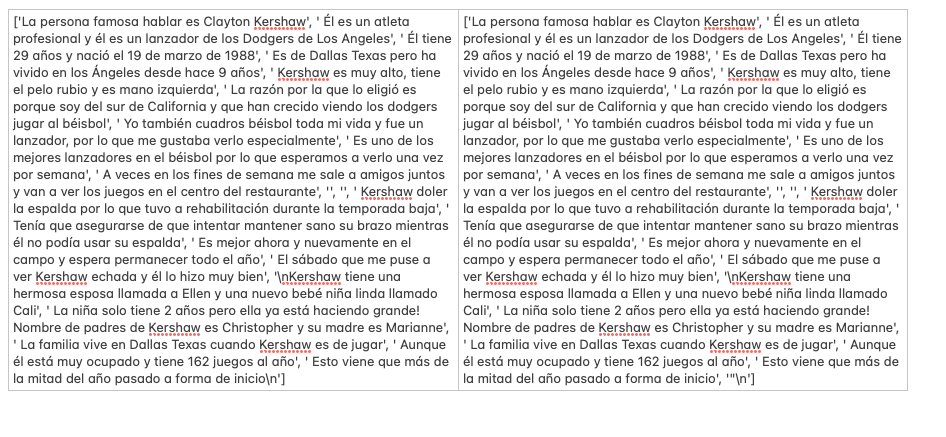

Choose the one that have more corrections from the strings

In [ ]:
pattern = r'\[.*?\]\{.*?\}\<.*?\>'

df['p_anno_error_cnt'] = df['a personal annotator1'].str.count(pattern)
df['p_anno2_error_cnt'] = df['a personal annotator2'].str.count(pattern)
df['g_anno1_error_cnt'] = df['gender-number annotator1'].str.count(pattern)
df['g_anno2_error_cnt'] = df['gender-number annotator2'].str.count(pattern)

In [ ]:
df['p_anno_error_cnt'] = df['p_anno_error_cnt'].fillna(0)
df['p_anno2_error_cnt'] = df['p_anno2_error_cnt'].fillna(0)
df['g_anno1_error_cnt'] = df['g_anno1_error_cnt'].fillna(0)
df['g_anno2_error_cnt'] = df['g_anno2_error_cnt'].fillna(0)

In [ ]:
df['p_annotator_new']= df.apply(lambda row: row['a personal annotator1'] if row['p_anno_error_cnt'] >= row['p_anno2_error_cnt'] else row['a personal annotator2'], axis = 1)

In [ ]:
df['g_annotator_new']= df.apply(lambda row: row['gender-number annotator1'] if row['g_anno1_error_cnt'] >= row['g_anno2_error_cnt'] else row['gender-number annotator2'], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 179
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                905 non-null    int64  
 1   id                        905 non-null    int64  
 2   prompt                    905 non-null    object 
 3   quarter                   905 non-null    object 
 4   course                    893 non-null    object 
 5   age                       887 non-null    object 
 6   gender                    889 non-null    object 
 7   l1 language               886 non-null    object 
 8   other l1 language(s)      177 non-null    object 
 9   language(s) used at home  641 non-null    object 
 10  language(s) studied       507 non-null    object 
 11  listening comprehension   827 non-null    float64
 12  reading comprehension     827 non-null    float64
 13  speaking ability          827 non-null    float64
 14  writing ab

In [ ]:
df['essay_new'] = df['essay'].apply(split_paragraph)
df['p_annotator_list'] = df['p_annotator_new'].apply(split_paragraph)
df['g_annotator_list'] = df['g_annotator_new'].apply(split_paragraph)

df['p_annotator_list_cnt'] =  df['p_annotator_list'].apply(lambda x: len(x))
df['g_annotator_list_cnt'] =  df['g_annotator_list'].apply(lambda x: len(x))

print(df[df['p_annotator_list_cnt'] != df['g_annotator_list_cnt']].shape)
print(df[df['essay_new_cnt'] != df['p_annotator_list_cnt']].shape)
print(df[df['essay_new_cnt'] != df['g_annotator_list_cnt']].shape)

(17, 45)
(16, 45)
(9, 45)


observation:
1. some of the sentences are missing from the annotation
2. removing the trailing \n


===========
to do: need to clean up the \n and fix the paragraph if they are not in the same length

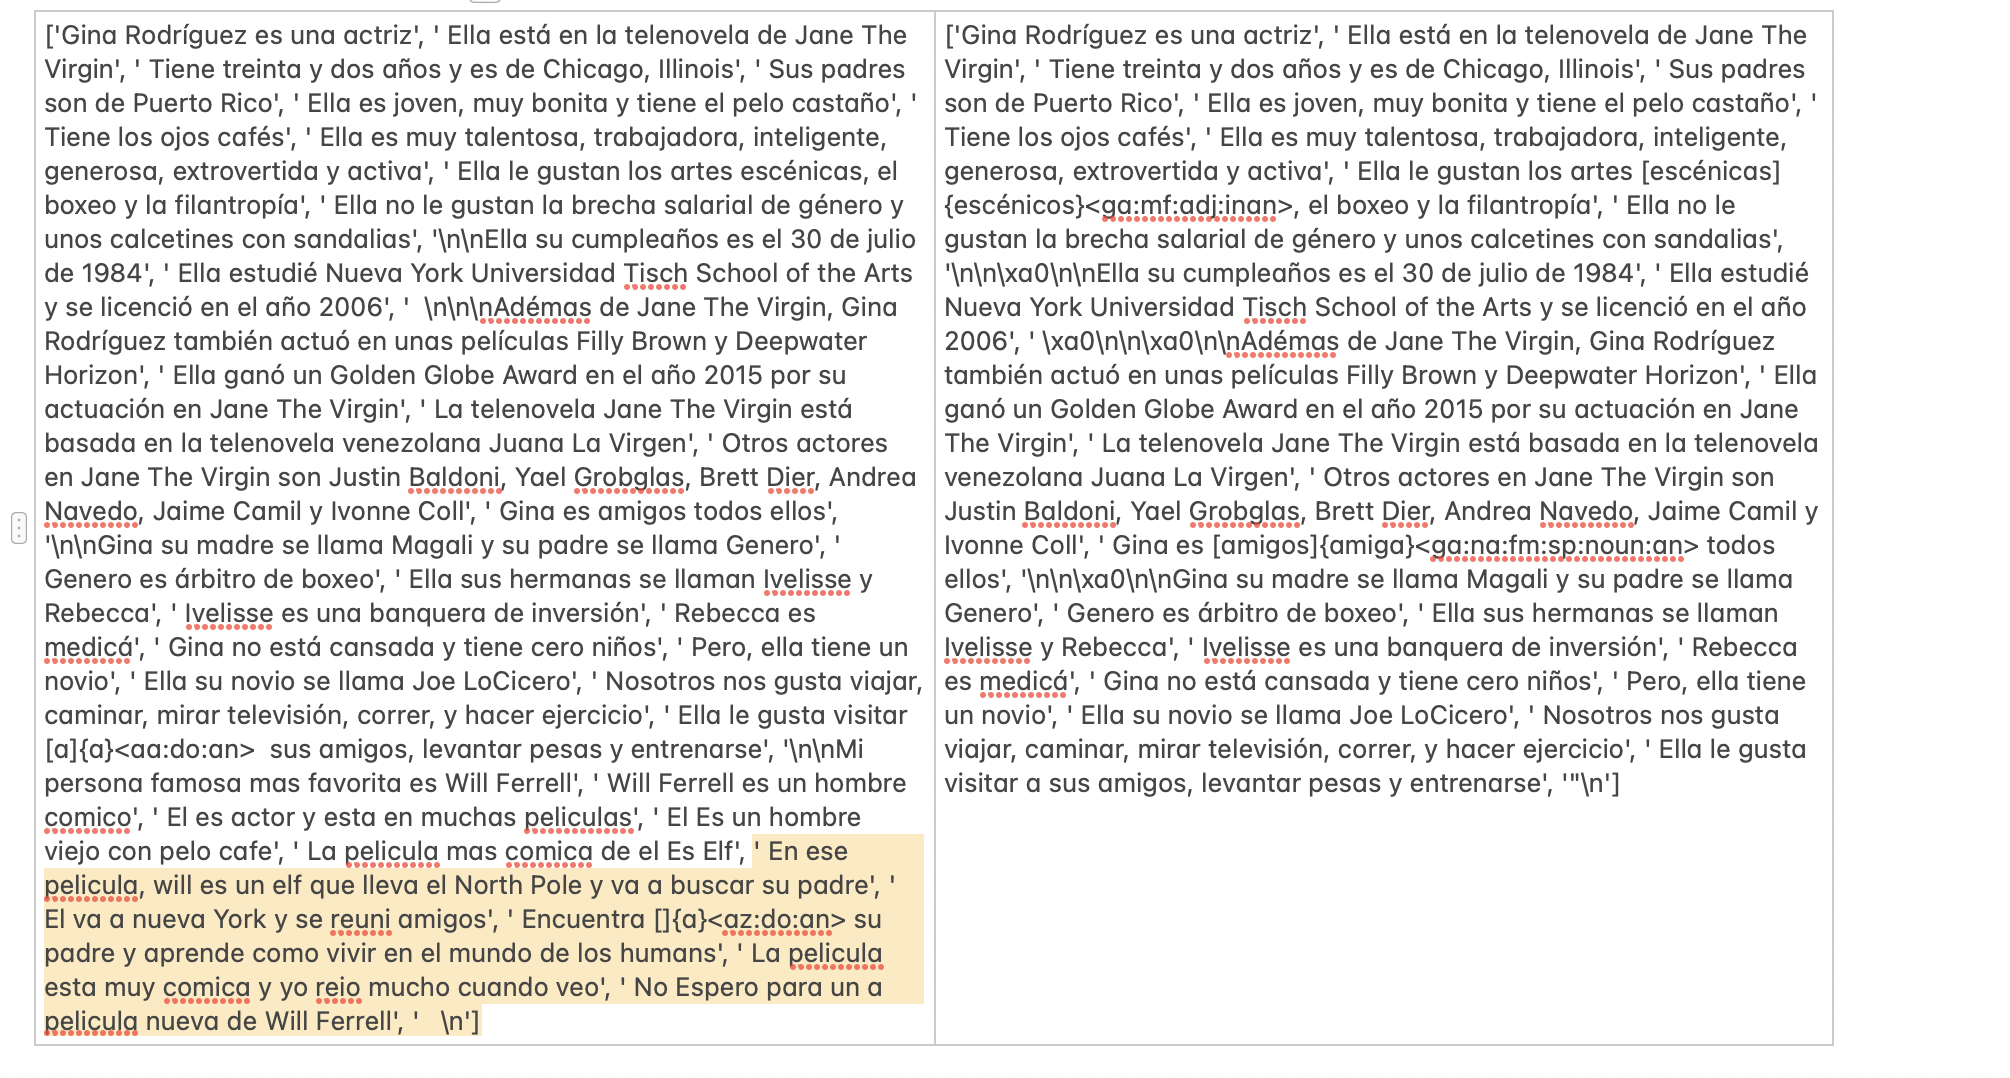

In [ ]:
test1 = df[(df['essay_new_cnt'] == df['p_annotator_list_cnt']) & (df['essay_new_cnt'] == df['p_annotator_list_cnt'])  &(df['essay_new_cnt'] == df['g_annotator_list_cnt']) ]
test1.to_csv('output_error.csv', index = False)

In [ ]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 0 to 179
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                884 non-null    int64  
 1   id                        884 non-null    int64  
 2   prompt                    884 non-null    object 
 3   quarter                   884 non-null    object 
 4   course                    872 non-null    object 
 5   age                       866 non-null    object 
 6   gender                    868 non-null    object 
 7   l1 language               865 non-null    object 
 8   other l1 language(s)      173 non-null    object 
 9   language(s) used at home  625 non-null    object 
 10  language(s) studied       496 non-null    object 
 11  listening comprehension   807 non-null    float64
 12  reading comprehension     807 non-null    float64
 13  speaking ability          807 non-null    float64
 14  writing ab

In [ ]:
df.columns.tolist()

['Unnamed: 0',
 'id',
 'prompt',
 'quarter',
 'course',
 'age',
 'gender',
 'l1 language',
 'other l1 language(s)',
 'language(s) used at home',
 'language(s) studied',
 'listening comprehension',
 'reading comprehension',
 'speaking ability',
 'writing ability',
 'study abroad',
 'essay',
 'a personal annotator1',
 'a personal annotator2',
 'gender-number annotator1',
 'gender-number annotator2',
 'corrected',
 'is_duplicated',
 'essay_new',
 'p_annotator1',
 'p_annotator2',
 'g_annotator1',
 'g_annotator2',
 'corrected_new',
 'p_annotator1_cnt',
 'p_annotator2_cnt',
 'g_annotator1_cnt',
 'g_annotator2_cnt',
 'essay_new_cnt',
 'corrected_new_cnt',
 'p_anno_error_cnt',
 'p_anno2_error_cnt',
 'g_anno1_error_cnt',
 'g_anno2_error_cnt',
 'p_annotator_new',
 'g_annotator_new',
 'p_annotator_list',
 'g_annotator_list',
 'p_annotator_list_cnt',
 'g_annotator_list_cnt']

In [ ]:
columns_to_explode = ['essay_new','p_annotator_list', 'g_annotator_list']

In [ ]:
final = test1.explode(columns_to_explode)

In [ ]:
df_final = final[['id',
 'prompt',
 'quarter',
 'course',
 'age',
 'gender',
 'l1 language',
 'other l1 language(s)',
 'language(s) used at home',
 'language(s) studied',
 'listening comprehension',
 'reading comprehension',
 'speaking ability',
 'writing ability',
 'study abroad',
 'is_duplicated',
 'essay_new',
 'p_annotator_list',
 'g_annotator_list']]

df_final

,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,language(s) studied,listening comprehension,reading comprehension,speaking ability,writing ability,study abroad,is_duplicated,essay_new,p_annotator_list,g_annotator_list
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,"Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario","Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario","Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que [un]{una}<ga:fm:det:an> simple [orador]{oradora}<ga:fm:gat:noun:an> [ordinario]{ordinaria}<ga:fm:adj:an>"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,2.0,2.0,2.0,2.0,No,False,Sus concierto es muy famoso por su energía y divertido,Sus concierto es muy famoso por su energía y divertido,[Sus]{su}<na:sp:det:inan> concierto es muy famoso por su energía y divertido
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,2.0,2.0,2.0,2.0,No,False,"Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar los differencias de los dos conciertos de los dos cantantes","Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar los differencias de los dos conciertos de los dos cantantes","Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar [los]{las}<ga:fm:det:inan> differencias de los dos conciertos de [los]{las}<ga:fm:det:an> dos cantantes"
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,2.0,2.0,2.0,2.0,No,False,"Al hacerlo, yo creo que entender las características de los culturas differentes en la música latina y la música americana","Al hacerlo, yo creo que entender las características de los culturas differentes en la música latina y la música americana","Al hacerlo, yo creo que entender las características de [los]{las}<ga:fm:det:inan> culturas differentes en la música latina y la música americana"
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,2.0,2.0,2.0,2.0,No,False,"También, yo quiero bailar con ella y sacar photos","También, yo quiero bailar con ella y sacar photos","También, yo quiero bailar con ella y sacar photos"


In [ ]:
df_final.replace('', np.nan, inplace = True)
df_final.replace(' ', np.nan, inplace = True)
df_final.replace('\n', np.nan, inplace = True)
df_final_v1 = df_final.dropna(subset=['essay_new'])
df_final_v2 = df_final_v1.dropna(subset=['p_annotator_list'])

<ipython-input-133-7b84490800a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.replace('', np.nan, inplace = True)
<ipython-input-133-7b84490800a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.replace(' ', np.nan, inplace = True)
<ipython-input-133-7b84490800a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.replace('\n', np.nan, inplace = True)


In [ ]:
df_final_v2

,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,language(s) studied,listening comprehension,reading comprehension,speaking ability,writing ability,study abroad,is_duplicated,essay_new,p_annotator_list,g_annotator_list
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,3.0,3.0,1.0,1.0,No,False,"Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario","Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario","Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que [un]{una}<ga:fm:det:an> simple [orador]{oradora}<ga:fm:gat:noun:an> [ordinario]{ordinaria}<ga:fm:adj:an>"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,2.0,2.0,2.0,2.0,No,False,\n\nYo quiero ir al concierto de ella mucho,\n\nYo quiero ir al concierto de ella mucho,\n\nYo quiero ir al concierto de ella mucho
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,2.0,2.0,2.0,2.0,No,False,Sus concierto es muy famoso por su energía y divertido,Sus concierto es muy famoso por su energía y divertido,[Sus]{su}<na:sp:det:inan> concierto es muy famoso por su energía y divertido
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,2.0,2.0,2.0,2.0,No,False,"Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar los differencias de los dos conciertos de los dos cantantes","Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar los differencias de los dos conciertos de los dos cantantes","Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar [los]{las}<ga:fm:det:inan> differencias de los dos conciertos de [los]{las}<ga:fm:det:an> dos cantantes"
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,2.0,2.0,2.0,2.0,No,False,"Al hacerlo, yo creo que entender las características de los culturas differentes en la música latina y la música americana","Al hacerlo, yo creo que entender las características de los culturas differentes en la música latina y la música americana","Al hacerlo, yo creo que entender las características de [los]{las}<ga:fm:det:inan> culturas differentes en la música latina y la música americana"


In [ ]:
df_final_v2.to_csv('output.csv', index = False)

# Analyzing encoded error

In [ ]:
pattern = r'\[.*?\]\{.*?\}\<.*?\>'

df_final_v2['p_anno_error_cnt'] = df_final_v2['p_annotator_list'].str.contains(pattern)
df_final_v2['g_anno_error_cnt'] = df_final_v2['g_annotator_list'].str.contains(pattern)

df_final_v2['p_anno_error_cnt'] = df_final_v2['p_anno_error_cnt'].fillna(0)
df_final_v2['g_anno_error_cnt'] = df_final_v2['g_anno_error_cnt'].fillna(0)

<ipython-input-137-73e90bdaf286>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_v2['p_anno_error_cnt'] = df_final_v2['p_annotator_list'].str.contains(pattern)
<ipython-input-137-73e90bdaf286>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_v2['g_anno_error_cnt'] = df_final_v2['g_annotator_list'].str.contains(pattern)
<ipython-input-137-73e90bdaf286>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [ ]:
df_final_v2

,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,language(s) studied,...,reading comprehension,speaking ability,writing ability,study abroad,is_duplicated,essay_new,p_annotator_list,g_annotator_list,p_anno_error_cnt,g_anno_error_cnt
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,3.0,1.0,1.0,No,False,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,False,False
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,3.0,1.0,1.0,No,False,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,False,False
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,3.0,1.0,1.0,No,False,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,False,False
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,3.0,1.0,1.0,No,False,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,False,False
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,3.0,1.0,1.0,No,False,"Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario","Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario","Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que [un]{una}<ga:fm:det:an> simple [orador]{oradora}<ga:fm:gat:noun:an> [ordinario]{ordinaria}<ga:fm:adj:an>",False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,...,2.0,2.0,2.0,No,False,\n\nYo quiero ir al concierto de ella mucho,\n\nYo quiero ir al concierto de ella mucho,\n\nYo quiero ir al concierto de ella mucho,False,False
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,...,2.0,2.0,2.0,No,False,Sus concierto es muy famoso por su energía y divertido,Sus concierto es muy famoso por su energía y divertido,[Sus]{su}<na:sp:det:inan> concierto es muy famoso por su energía y divertido,False,True
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,...,2.0,2.0,2.0,No,False,"Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar los differencias de los dos conciertos de los dos cantantes","Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar los differencias de los dos conciertos de los dos cantantes","Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar [los]{las}<ga:fm:det:inan> differencias de los dos conciertos de [los]{las}<ga:fm:det:an> dos cantantes",False,True
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,...,2.0,2.0,2.0,No,False,"Al hacerlo, yo creo que entender las características de los culturas differentes en la música latina y la música americana","Al hacerlo, yo creo que entender las características de los culturas differentes en la música latina y la música americana","Al hacerlo, yo creo que entender las características de [los]{las}<ga:fm:det:inan> culturas differentes en la música latina y la música americana",False,True


### Data Analysis

% of sentences with grammartical mistake.

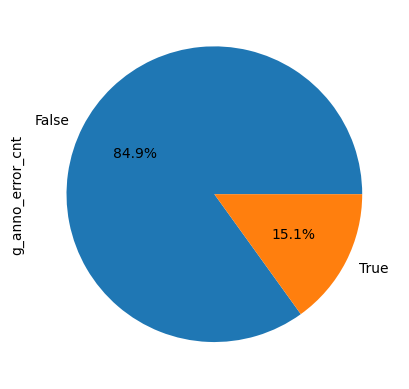

In [ ]:
counts = df_final_v2['g_anno_error_cnt'].value_counts()
counts.plot.pie(autopct= '%1.1f%%')
plt.show()

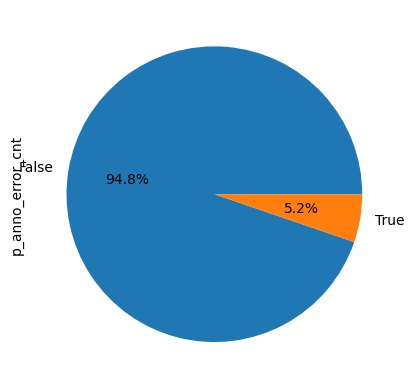

In [ ]:
counts = df_final_v2['p_anno_error_cnt'].value_counts()
counts.plot.pie(autopct= '%1.1f%%')
plt.show()

extracting all the tag

In [ ]:
df_final_v2['p_annotator_error_tag'] = df_final_v2['p_annotator_list'].str.findall('<(.*?)>')
df_final_v2['g_annotator_error_tag'] = df_final_v2['g_annotator_list'].str.findall('<(.*?)>')
# df_final_v2['g_annotator_error_tag'] = df_final_v2['g_annotator_list'].str.extractall('<(.*?)>')

<ipython-input-155-d9210f16484d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_v2['p_annotator_error_tag'] = df_final_v2['p_annotator_list'].str.findall('<(.*?)>')
<ipython-input-155-d9210f16484d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_v2['g_annotator_error_tag'] = df_final_v2['g_annotator_list'].str.findall('<(.*?)>')


In [ ]:
df_final_v2

,id,prompt,quarter,course,age,gender,l1 language,other l1 language(s),language(s) used at home,language(s) studied,...,writing ability,study abroad,is_duplicated,essay_new,p_annotator_list,g_annotator_list,p_anno_error_cnt,g_anno_error_cnt,p_annotator_error_tag,g_annotator_error_tag
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,1.0,No,False,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,Una persona famosa que admiro es Lauren Jauregui,False,False,[],[]
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,1.0,No,False,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,Ella es una cantante en el grupo Fifth Harmony,False,False,[],[]
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,1.0,No,False,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,Ella ha asumido su papel de cantante que muchas chicas admiran y persiguen,False,False,[],[]
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,1.0,No,False,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,Ella habla en contra del fanatismo y el odio y apoya el amor propio y la felicidad personal,False,False,[],[]
0,146362,famous,F17,SPA 2,19,Female,English,NaN,NaN,NaN,...,1.0,No,False,"Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario","Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que un simple orador ordinario","Muchas niñas, especialmente las niñas que son homosexuales, creen que ella es un héroe y algo más que [un]{una}<ga:fm:det:an> simple [orador]{oradora}<ga:fm:gat:noun:an> [ordinario]{ordinaria}<ga:fm:adj:an>",False,True,[],"[ga:fm:det:an, ga:fm:gat:noun:an, ga:fm:adj:an]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,...,2.0,No,False,\n\nYo quiero ir al concierto de ella mucho,\n\nYo quiero ir al concierto de ella mucho,\n\nYo quiero ir al concierto de ella mucho,False,False,[],[]
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,...,2.0,No,False,Sus concierto es muy famoso por su energía y divertido,Sus concierto es muy famoso por su energía y divertido,[Sus]{su}<na:sp:det:inan> concierto es muy famoso por su energía y divertido,False,True,[],[na:sp:det:inan]
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,...,2.0,No,False,"Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar los differencias de los dos conciertos de los dos cantantes","Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar los differencias de los dos conciertos de los dos cantantes","Yo solamente fui al concierto de Katy Perry, por eso, yo quiero comparar [los]{las}<ga:fm:det:inan> differencias de los dos conciertos de [los]{las}<ga:fm:det:an> dos cantantes",False,True,[],"[ga:fm:det:inan, ga:fm:det:an]"
179,179355,famous,W18,SPA 2,Female,20,Other,Japanese,Japanese,English 14 years,...,2.0,No,False,"Al hacerlo, yo creo que entender las características de los culturas differentes en la música latina y la música americana","Al hacerlo, yo creo que entender las características de los culturas differentes en la música latina y la música americana","Al hacerlo, yo creo que entender las características de [los]{las}<ga:fm:det:inan> culturas differentes en la música latina y la música americana",False,True,[],[ga:fm:det:inan]


In [ ]:
df_final_3 = df_final_v2.explode('p_annotator_error_tag')

<Axes: >

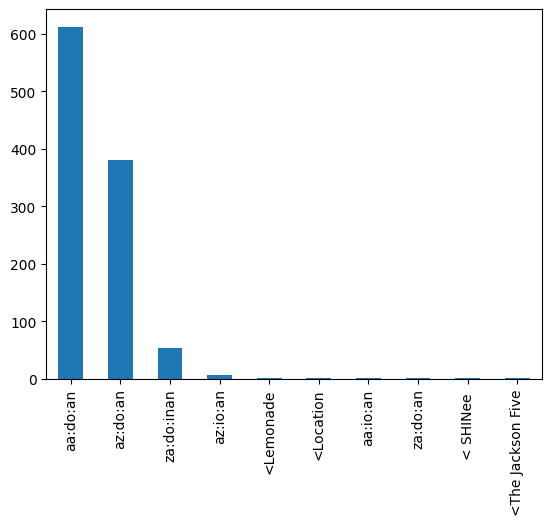

In [ ]:
counts = df_final_3.p_annotator_error_tag.value_counts()
counts.plot.bar()

<Axes: >

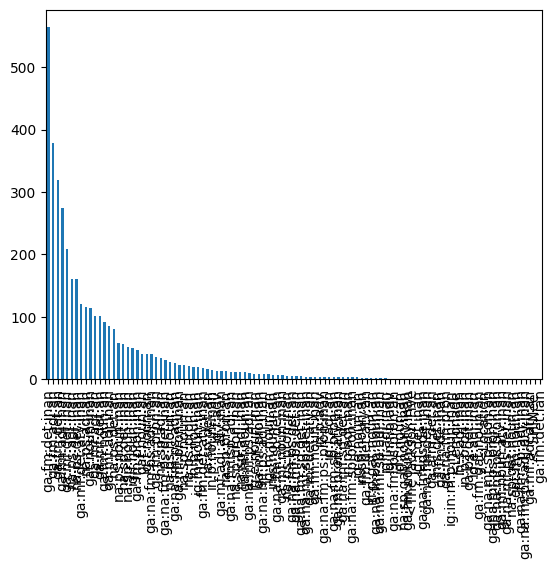

In [ ]:
df_final_4 = df_final_v2.explode('g_annotator_error_tag')
counts = df_final_4.g_annotator_error_tag.value_counts()
counts.plot.bar()


### Sentence length

In [ ]:
senten